# TP3 -- Travail pratique 3 : étude de cas Yelp

## Importation des librairies

In [38]:
import numpy as np
import pandas as pd


## Importation les csv

In [39]:
path = './Data_use_case_Yelp/use_case/'
# path_sample = path + 'sample'

review_file = 'avis.csv'
categorie_file = 'categories.csv'
checkin_file = 'checkin.csv'
conseil_file = 'conseils.csv'
horaires_file = 'horaires.csv'
restaurant_features_file = 'restaurants_features.csv'
restaurant_file = 'restaurants.csv'
services_file = 'services.csv'
utilisateurs_file = 'utilisateurs.csv'

## Chargement des données dans le dataframes

In [40]:
services = pd.read_csv(path + services_file, skip_blank_lines=True)
categories = pd.read_csv(path + categorie_file, skip_blank_lines=True)
horaires = pd.read_csv(path + horaires_file, skip_blank_lines=True)
business = pd.read_csv(path + restaurant_file, skip_blank_lines=True)
tip = pd.read_csv(path + conseil_file, skip_blank_lines=True)
checkins = pd.read_csv(path + checkin_file, skip_blank_lines=True)
user = pd.read_csv(path + utilisateurs_file, skip_blank_lines=True)
reviews = pd.read_csv(path + review_file, skip_blank_lines=True)
restaurant_features = pd.read_csv(path + restaurant_features_file, skip_blank_lines=True)

## Intégration et calcul des indicateurs

### Attribution d'une moyenne d'étoiles par restaurants

In [41]:
avg_stars = reviews.groupby('restaurant_id')['etoiles'].mean().reset_index(name='avg_stars')
print(avg_stars.head())

            restaurant_id  avg_stars
0  --1UhMGODdWsrMastO9DZw   4.076923
1  --6MefnULPED_I942VcFNA   3.173913
2  --DaPTJW3-tB1vP-PfdTEg   3.714286
3  --FBCX-N37CMYDfs790Bnw   3.746479
4  --KCl2FvVQpvjzmZSPyviA   3.066667


### Récupéreration du nombres d'avis par restaurants

In [42]:
review_count_total = reviews.groupby('restaurant_id')['etoiles'].count().reset_index(name='review_count_total')
print(review_count_total.head())

            restaurant_id  review_count_total
0  --1UhMGODdWsrMastO9DZw                  26
1  --6MefnULPED_I942VcFNA                  46
2  --DaPTJW3-tB1vP-PfdTEg                  49
3  --FBCX-N37CMYDfs790Bnw                 142
4  --KCl2FvVQpvjzmZSPyviA                  15


### Récupéreration ratio d'avis favorables (étoile > 4)

In [43]:
positive_review_count = reviews[reviews['etoiles'] >= 4].groupby('restaurant_id')['avis_id'].count().reset_index(name='positif_review_count')
print(positive_review_count.head())

            restaurant_id  positif_review_count
0  --1UhMGODdWsrMastO9DZw                    21
1  --6MefnULPED_I942VcFNA                    21
2  --DaPTJW3-tB1vP-PfdTEg                    32
3  --FBCX-N37CMYDfs790Bnw                    98
4  --KCl2FvVQpvjzmZSPyviA                     6


### Nombres totales de check-ins

In [44]:
checkins_total = checkins.groupby('restaurant_id')['date'].count().reset_index(name='checkins_total')
print(checkins_total.head())

            restaurant_id  checkins_total
0  --1UhMGODdWsrMastO9DZw               6
1  --6MefnULPED_I942VcFNA             167
2  --DaPTJW3-tB1vP-PfdTEg              95
3  --FBCX-N37CMYDfs790Bnw             528
4  --KCl2FvVQpvjzmZSPyviA             100


### Indication de si un restaurant fait parti d'une chaine

In [45]:
business['is_chain'] = business.groupby('nom')['restaurant_id'].transform('count') >= 3
print((business.groupby('nom')['restaurant_id'].transform('count') >= 3).head())

0     True
1    False
2    False
3    False
4    False
Name: restaurant_id, dtype: bool


### Cout moyen du restautant

In [46]:
prices = services[['restaurant_id', 'prix']].rename(columns={'prix': 'price_range'})
print(prices.head())

            restaurant_id  price_range
0  lCwqJWMxvIUQt1Re_tDn4w            2
1  pd0v6sOqpLhFJ7mkpIaixw            2
2  0vhi__HtC2L4-vScgDFdFw            2
3  t65yfB9v9fqlhAkLnnUXdg            1
4  i7_JPit-2kAbtRTLkic2jA            3


### Nombre d'utilisateur élite ayant commenté le restaurant

In [47]:
reviews_by_elites = reviews.merge(user[['utilisateur_id', 'elite']], on='utilisateur_id', how='left')

elite_review = reviews_by_elites[reviews_by_elites['elite'] == 1]

elite_users_count = elite_review.groupby('restaurant_id')['utilisateur_id'].nunique().reset_index(name='elite_user_count')

print("Elites user count :")
print(elite_users_count.head())
print("Reviews by elites :")
print(reviews_by_elites.head())
print("Reviews elites :")
print(elite_review.head())

Elites user count :
            restaurant_id  elite_user_count
0  --1UhMGODdWsrMastO9DZw                 5
1  --6MefnULPED_I942VcFNA                23
2  --DaPTJW3-tB1vP-PfdTEg                 8
3  --FBCX-N37CMYDfs790Bnw                20
4  --KCl2FvVQpvjzmZSPyviA                 3
Reviews by elites :
                  avis_id          utilisateur_id           restaurant_id  \
0  yi0R0Ugj_xUx_Nek0-_Qig  dacAIZ6fTM6mqwW5uxkskg  ikCg8xy5JIg_NGPx-MSIDA   
1  8e9HxxLjjqc9ez5ezzN7iQ  d6xvYpyzcfbF_AZ8vMB7QA  zvO-PJCpNk4fgAVUnExYAA   
2  Z7wgXp98wYB57QdRY3HQ3w  GYNnVehQeXjty0xH7-6Fhw  FxLfqxdYPA6Z85PFKaqLrg   
3  JVcjMhlavKKn3UIt9p9OXA  TpyOT5E16YASd7EWjLQlrw  AakkkTuGZA2KBodKi2_u8A   
4  6BnQwlxRn7ZuWdzninM9sQ  JSrP-dUmLlwZiI7Dp3PQ2A  cHdJXLlKNWixBXpDwEGb_A   

   etoiles  useful  funny  cool                 date  elite  
0      5.0       0      0     0  2018-01-09 20:56:38      0  
1      1.0       3      1     1  2010-10-05 19:12:35      0  
2      4.0       0      0     0  2016-05-07 01:

### Moyenne des heures d’ouverture par jour

In [48]:
from datetime import datetime, timedelta

#### : spliter les horaires d'ouverture ( ouvreture : 0:00 fermeture : 23:59 et les transforme en heures)
def duration_opening_hours(time):
    try:
        ### valdier le format
        if pd.isna(time) or str(time).strip() in ['', '0:0-0:0', '0:00-0:00']:
            return 0
        
        time = str(time).strip()
        opening, closing = time.split('-')
        opening_dt = datetime.strptime(opening, '%H:%M')
        closing_dt = datetime.strptime(closing, '%H:%M')
        
        # si fermeture après minuit
        if closing_dt < opening_dt:
            closing_dt += timedelta(days=1)
        
        duration = (closing_dt - opening_dt).seconds / 3600
        return duration
    except Exception as e:
        # print("Erreur pour time =", time, ":", e)
        return 0

### Exraire les jours de la semaines
days = [col for col in horaires.columns if col != 'restaurant_id']

### apply la fonction pour split l'horaire à chaque jour de la semaine
for day in days:
    horaires[day] = horaires[day].apply(duration_opening_hours)

### Calcul de la moyenne des heures d'ouverture par jour
horaires['avg_opening_hours'] = horaires[days].mean(axis=1).round(2)
avg_opening_hours = horaires[['restaurant_id', 'avg_opening_hours']]

print(avg_opening_hours.head())

            restaurant_id  avg_opening_hours
0  lCwqJWMxvIUQt1Re_tDn4w               0.00
1  pd0v6sOqpLhFJ7mkpIaixw               9.14
2  0vhi__HtC2L4-vScgDFdFw               9.64
3  t65yfB9v9fqlhAkLnnUXdg               8.14
4  i7_JPit-2kAbtRTLkic2jA               7.93


## Rassemblement du tout dans un dataframe 

In [49]:

dataset = business[['restaurant_id', 'nom', 'ville']].merge(avg_stars, on='restaurant_id', how='left') \
    .merge(review_count_total, on='restaurant_id', how='left') \
    .merge(positive_review_count, on='restaurant_id', how='left') \
    .merge(checkins_total, on='restaurant_id', how='left') \
    .merge(elite_users_count, on='restaurant_id', how='left') \
    .merge(avg_opening_hours, on='restaurant_id', how='left') \
    .merge(business[['restaurant_id', 'is_chain']], on='restaurant_id', how='left') \
    .merge(prices, on='restaurant_id', how='left')

### Ratio positif d'avis

In [50]:
positive_ratio = dataset['positive_ratio'] = dataset['positif_review_count'] / dataset['review_count_total']

# Remplacer les NaN et arrondir
dataset['positive_ratio'] = dataset['positive_ratio'].fillna(0).round(3)

print(positive_ratio.head())

0    0.305556
1    0.759259
2    0.673469
3    0.583333
4    0.715909
dtype: float64


## Ajout du dataset dans le fichier restaurant_features_file.csv

In [51]:
### formatage 
dataset['avg_stars'] = dataset['avg_stars'].round(2)
dataset['positif_review_count'] = dataset['positif_review_count'].fillna(0).astype(int)
dataset['elite_user_count'] = dataset['elite_user_count'].fillna(0).astype(int)
dataset['checkins_total'] = dataset['checkins_total'].fillna(0).astype(int)

dataset.to_csv(path + restaurant_features_file, index=False)

In [52]:
restaurant_features

,restaurant_id,nom,ville,avg_stars,review_count_total,positif_review_count,checkins_total,elite_user_count,avg_opening_hours,is_chain,price_range,positive_ratio
0,lCwqJWMxvIUQt1Re_tDn4w,Denny's,Las Vegas,2.40,72,22,181,6,0.00,True,2,0.306
1,pd0v6sOqpLhFJ7mkpIaixw,Ike's Love & Sandwiches,Phoenix,4.19,108,82,492,23,9.14,False,2,0.759
2,0vhi__HtC2L4-vScgDFdFw,Midori Japanese Cafe,Calgary,3.67,49,33,157,26,9.64,False,2,0.673
3,t65yfB9v9fqlhAkLnnUXdg,Pho U,Toronto,3.56,36,21,18,3,8.14,False,1,0.583
4,i7_JPit-2kAbtRTLkic2jA,John & Sons Oyster House,Toronto,3.85,88,63,110,36,7.93,False,3,0.716
...,...,...,...,...,...,...,...,...,...,...,...,...
34263,cjZfgcQwA6KmQ_ANWKN2aw,Bruegger's Bagels,McMurray,3.67,6,4,37,1,8.00,True,1,0.667
34264,Hq2edcOTjse7wjK2CwBijQ,Bistro Pointe-Claire,Pointe-Claire,3.64,11,6,5,0,9.79,False,2,0.545
34265,7KlpgRjjAmVabPzxcExs0g,Taco Mex,Phoenix,4.00,11,8,32,1,0.00,False,1,0.727
34266,0fY-zYyP2fDmp2YXFsuNTg,Gotham Provisions Company,Sun Prairie,4.11,18,13,7,1,5.00,False,1,0.722


## Nettoyage des données

### Colonnes numériques

In [53]:
numeric_cols = ['avg_stars', 'review_count_total', 'positif_review_count', 'checkins_total', 'elite_user_count', 'avg_opening_hours']
for col in numeric_cols:
    if col in dataset.columns:
        if 'avg' in col:
            #remplacer NA par la moyenne et arrondir
            dataset[col] = dataset[col].fillna(dataset[col].mean()).round(2)
        else:
            #remplacer NA par 0 et convertir en int
            dataset[col] = dataset[col].fillna(0).astype(int)

### Colonnes booléenes

In [54]:
if 'is_chain' in dataset.columns:
    dataset['is_chain'] = dataset['is_chain'].fillna(False).astype(bool)

### Colonnes textuelles

In [55]:
text_cols = ['nom', 'ville']
for col in text_cols:
    if col in dataset.columns:
        dataset[col] = dataset[col].fillna('')

### Vérification

In [56]:
print("Vérification des valeurs manquantes après nettoyage :")
print(dataset.isnull().sum())

Vérification des valeurs manquantes après nettoyage :
restaurant_id           0
nom                     0
ville                   0
avg_stars               0
review_count_total      0
positif_review_count    0
checkins_total          0
elite_user_count        0
avg_opening_hours       0
is_chain                0
price_range             0
positive_ratio          0
dtype: int64


In [57]:
print("Infos dataset après nettoyage :")
print(dataset.info())

Infos dataset après nettoyage :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34268 entries, 0 to 34267
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   restaurant_id         34268 non-null  object 
 1   nom                   34268 non-null  object 
 2   ville                 34268 non-null  object 
 3   avg_stars             34268 non-null  float64
 4   review_count_total    34268 non-null  int64  
 5   positif_review_count  34268 non-null  int64  
 6   checkins_total        34268 non-null  int64  
 7   elite_user_count      34268 non-null  int64  
 8   avg_opening_hours     34268 non-null  float64
 9   is_chain              34268 non-null  bool   
 10  price_range           34268 non-null  int64  
 11  positive_ratio        34268 non-null  float64
dtypes: bool(1), float64(3), int64(5), object(3)
memory usage: 2.9+ MB
None


# PREMIER GRAPHIQUE — STATIQUE
## Histogramme des notes moyennes des restaurants

In [58]:
###Import 
import matplotlib.pyplot as plt

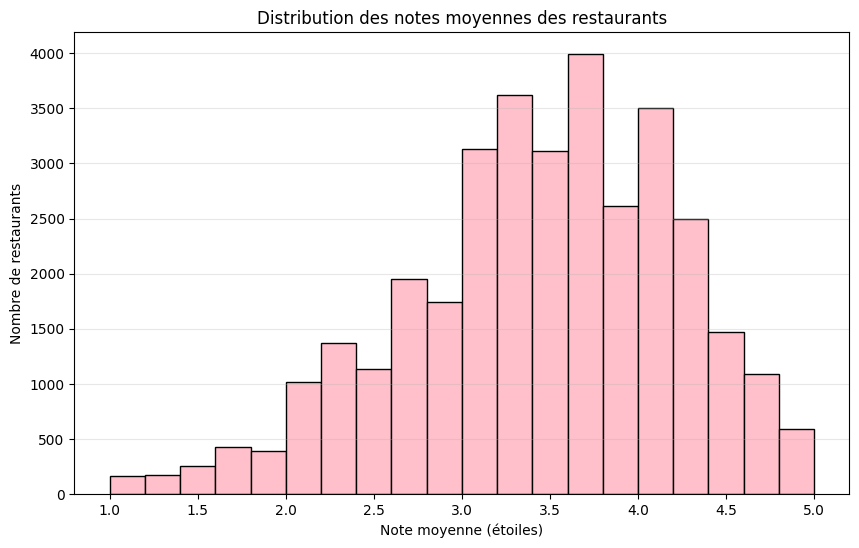

In [59]:
##Taille 
plt.figure(figsize=(10, 6))

## création histogramme
plt.hist(dataset['avg_stars'], bins=20, color='pink', edgecolor='black')

## Ajouter des titres et des labels
plt.title("Distribution des notes moyennes des restaurants")
plt.xlabel("Note moyenne (étoiles)")
plt.ylabel("Nombre de restaurants")

## Rendre le graphique plus lisible
plt.grid(axis='y', alpha=0.3)

##Affiche
plt.show()


# DEUXIÈME GRAPHIQUE — INTERACTIF
## Relation entre le nombre d'avis et le ratio positif, filtré par ville avec un menu 

In [35]:
# Import
from ipywidgets import interact


In [37]:
## Filtré par ville avec un menu
def graphique_par_ville(ville_choisie):

    ## Filtrer les données pour la ville choisie
    données_ville = dataset[dataset["ville"] == ville_choisie]

    ## Création du graphique
    plt.figure(figsize=(8,5))

    ## Création du nuage de points
    plt.scatter(
        données_ville["review_count_total"], 
        données_ville["positive_ratio"], 
        alpha=0.6
    )
    
    ## Titres et labels
    plt.title(f"Relation entre le nombre d'avis et le ratio positif – {ville_choisie}")
    plt.xlabel("Nombre total d'avis")
    plt.ylabel("Ratio d'avis positifs")

    ## Rendre le graphique plus lisible
    plt.grid(alpha=0.3)

    ## afficher
    plt.show()

## ca crée un menu pour choisir la ville.
interact(graphique_par_ville, ville_choisie=sorted(dataset["ville"].unique()))

interactive(children=(Dropdown(description='ville_choisie', options=('AGINCOURT', 'Ahwatukee', 'Airdrie', 'Aja…

<function __main__.graphique_par_ville(ville_choisie)>

## 1) Graphique statique : Distribution des notes moyennes

#### Quand on regarde le graphique, on voit que la plupart des restaurants ont une note entre 3 et 4,5 étoiles. Ça veut dire que, en général, les gens aiment bien les restaurants. Les notes très très hautes (4.5+) sont rares, comme si c’était dur d’être “parfait”. Et les notes très basses (moins de 3) sont presque absentes, donc il y a très peu de restaurants vraiment mauvais dans notre ensemble.

## 2) Graphique interactif : avis vs ratio positif

#### Quand on change de ville, on voit toujours un peu la même chose : les restaurants qui ont très peu d’avis ont un ratio positif qui bouge dans tous les sens. Certains se retrouvent avec un ratio parfait juste parce qu’ils ont reçu 3–4 bons avis, et d’autres tombent très bas après un seul mauvais commentaire. Par contre, dès qu’un restaurant accumule beaucoup d’avis, son ratio devient beaucoup plus stable et tourne presque toujours autour des mêmes valeurs. En comparant les villes entre elles, on remarque aussi que celles où il y a plus de restaurants avec un grand nombre d’avis ont des ratios beaucoup plus constants. Les villes avec peu d’avis (comme Blainville ou Bridgeville) montrent des résultats plus dispersés et donc moins fiables. Globalement, on peut dire que plus un restaurant reçoit d’avis, plus son ratio positif est crédible et reflète mieux la qualité réelle.

# Analyse et Interprétation 



## 1.

#### D'autres restaurants, même avec un bon potentiel, paraissent mal partis juste parce qu’un ou deux clients ont laissé une mauvaise note tôt. Ça montre que le début d’un restaurant peut être très fragile et pas toujours représentatif de la vraie qualité.

## 2.

#### Dans des villes où les restos ont peu d’avis, un ratio parfait (1.0) apparaît souvent , mais c’est trompeur. Par exemple à Blainville, un resto peut apparaître “parfait” avec seulement 4 avis. Le graphique nous montre que le ratio seul n’est pas un bon indicateur sans regarder combien d’avis il y a derrière.

## 3. 

#### Quand un restaurant devient populaire et reçoit beaucoup d’avis, son ratio commence un peu à “se calmer”. Peu importe la ville, on dirait que les gens finissent par se mettre d’accord : le ratio tourne presque toujours autour de 0,7 à 0,9.

## 4.

#### Quand on compare Calgary, Bridgeville, Blainville et Brooklyn, on voit vite que chaque ville a un caractère différent sur Yelp. Calgary, par exemple, a plein de restaurants très commentés : on sent que les gens là-bas aiment donner leur avis. Blainville, au contraire, a surtout des restos avec très peu d’avis, comme si la communauté Yelp était plus tranquille ou un peu timide.